In [2]:
#2/4 06:49
import numpy as np  
from numpy  import array
import pandas as pd
from keras.models import Sequential  
from keras.optimizers import RMSprop , Adam
from keras.layers import GaussianNoise, Dense , Conv2D , Activation , Dropout , Flatten , BatchNormalization , Reshape , UpSampling2D ,Conv2DTranspose,MaxPooling2D
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import np_utils
import h5py
import os
from os import listdir
from os.path import isfile, isdir, join
from keras import backend as K
from PIL import Image
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'




Using TensorFlow backend.


In [3]:
batch_size = 64;

In [4]:
mypath = "fruit"
files = listdir(mypath)
label = 1
imglist = []
labellist= []
fruitname = []
for f in files:
    fullpath = join(mypath, f)
    print("目錄：", f)
    fruitname.append(f)
    files2 = listdir(fullpath)
    for f2 in files2:
        fullpath2 = join(fullpath, f2)
        img=np.array(Image.open(fullpath2))
        o = np.ones(img.shape)
        img = img - (o * 127.5) 
        img = img / 127.5
        img=img
        imglist.append(img)
        labellist.append(label)
    label = label + 1



目錄： Apple
目錄： Banana
目錄： Carambula
目錄： Cherry
目錄： Grape Pink
目錄： Grape White
目錄： Guava
目錄： Kiwi
目錄： Lemon
目錄： Litchi
目錄： Mandarine
目錄： Orange
目錄： Passion Fruit
目錄： Peach
目錄： Pear
目錄： Pineapple
目錄： Pitahaya Red
目錄： Plum
目錄： Pomegranate
目錄： Strawberry


In [5]:
combined = list(zip(imglist, labellist))
random.shuffle(combined)
imglist[:], labellist[:] = zip(*combined)
#print(imglist[1888])
#print(labellist[1888])

In [6]:
RealY = np_utils.to_categorical(labellist,num_classes=21)
RealY = RealY*0.85
RealY

array([[ 0.  ,  0.85,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.85,  0.  , ...,  0.  ,  0.  ,  0.  ]])

In [7]:
#鑑定器 D
# In: 100 x 100 x 1, depth = 3
modelD = Sequential()

modelD.add(Conv2D(filters=16, strides=2 , kernel_size=(5, 5), padding='same', input_shape=(100, 100, 3)))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=32, strides=2 , kernel_size=(5, 5), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=64, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))

modelD.add(Conv2D(filters=128, strides=2 , kernel_size=(3, 3), padding='same'))
modelD.add(BatchNormalization())
modelD.add(LeakyReLU(0.2))
           
#modelD.add(Dropout(0.2))
modelD.add(Flatten())
modelD.add(Dense(21))
modelD.add(Activation('sigmoid'))
modelD.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 50, 50, 16)        1216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        18496     
__________

In [8]:
#生成器 G
# In: 512
modelG = Sequential()
modelG.add(Dense(25*25*256, input_dim=120))
modelG.add(Activation('relu'))
#modelG.add(Dropout(0.3))
modelG.add(Reshape((25, 25, 256)))
modelG.add(Conv2DTranspose(256, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))

modelG.add(Conv2DTranspose(128, kernel_size = (5,5), strides=(2, 2), padding='same'))
modelG.add(BatchNormalization())
modelG.add(Activation('relu'))


modelG.add(Conv2DTranspose(3, kernel_size = (5,5), strides=(1, 1), padding='same'))
#modelG.add(BatchNormalization())
modelG.add(Activation('tanh'))
modelG.add(Reshape((100, 100, 3)))
modelG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 160000)            19360000  
_________________________________________________________________
activation_2 (Activation)    (None, 160000)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 256)       1638656   
_________________________________________________________________
batch_normalization_5 (Batch (None, 50, 50, 256)       1024      
_________________________________________________________________
activation_3 (Activation)    (None, 50, 50, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 100, 100, 128)     819328    
__________

In [9]:
#D
optimizerD = Adam(0.0002, 0.5)
modelTD = Sequential()
modelTD.add(modelD)
modelTD.compile(loss='binary_crossentropy', optimizer=optimizerD,metrics=['accuracy'])
#A1
optimizerA = Adam(0.00015, 0.5)
modelTA = Sequential()
modelTA.add(modelG)
modelTA.add(modelTD)
modelTD.trainable = False
modelTA.compile(loss='binary_crossentropy', optimizer=optimizerA,metrics=['accuracy'])

In [10]:
a_loss_record = []
d_loss_record = []
dF_loss_record = []
dR_loss_record = []

In [11]:
def TrainG():
    Fake_Lable = np.random.randint(0, 20, batch_size)
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[batch_size, 100]) 
    NT = np.hstack((Fake_Lable,noise))
    #YA = np.ones([batch_size, 1])
    #YA = YA  * 0.85
    YA = Fake_Lable * 0.85
    YA = np.hstack((np.zeros([batch_size, 1]),YA))
    a_loss = modelTA.train_on_batch(NT,YA)
    a_loss_record.append(a_loss[0])
    print ("A1")
    print (a_loss)
    return a_loss

In [12]:
imgarray = np.asarray(imglist)
imgarray.shape

(12355, 100, 100, 3)

In [13]:
def TrainD():
    Rnd = np.random.randint(0,imgarray.shape[0],size = int(batch_size/2))
    RealX = imgarray[Rnd,:,:,:]    
    YA = RealY[Rnd]    
    #YA = np.ones([int(batch_size/2), 1])
    YA = YA  * 0.85
    
    YZ = np.zeros([int(batch_size/2), 1])
    YZ = np_utils.to_categorical(YZ,num_classes=21)
    YZ = YZ  * 0.85
    
    Fake_Lable = np.random.randint(0, 20, int(batch_size/2))
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[int(batch_size/2), 100]) 
    NT = np.hstack((Fake_Lable,noise))
    
    FakeX = modelG.predict(NT)
                                             
    gauss = np.random.normal(0,0.25,(int(batch_size/2),100,100,3))
    RealGX = RealX + gauss
    gauss = np.random.normal(0,0.25,(int(batch_size/2),100,100,3))
    FakeGX = FakeX + gauss 

    d_lossR = modelTD.train_on_batch(RealGX, YA)
    print ("D1R")
    print (d_lossR)
    d_lossF = modelTD.train_on_batch(FakeGX, YZ)
    print ("D1F")
    print (d_lossF)
    #
    d_loss =  (d_lossR[0] +  d_lossF[0]) / 2
    d_loss_record.append(d_loss)
  #  print ("D")
  #  print (d_loss)
    dR_loss_record.append(d_lossR[0])
    dF_loss_record.append(d_lossF[0])
    return d_loss
    

In [14]:
def Show(path):
    Fake_Lable = np.random.randint(0, 20, 1)
    k = Fake_Lable[0]
    Fake_Lable = np_utils.to_categorical(Fake_Lable,num_classes=20)
    noise = np.random.uniform(-0.8, 0.8, size=[1, 100]) 
    NT = np.hstack((Fake_Lable,noise))                                       
    FakeX = modelG.predict(NT)
    img = FakeX[0]
    img = img.reshape(100,100,3)
    img = img * 0.5 + 0.5
    plt.figure(figsize=(5,5))
    
    plt.title(fruitname[k])
    plt.imshow(img)
    plt.savefig(path)
    plt.show()
   

In [15]:
def ShowPlt():
    plt.plot(d_loss_record,label="d_loss")
    plt.plot(a_loss_record,label="a_loss")
    plt.plot(dR_loss_record,label="dR_loss")
    plt.plot(dF_loss_record,label="dF_loss")
    plt.legend()
    plt.show()


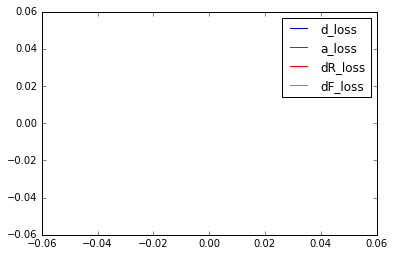

In [ ]:
ShowPlt()

0


c:\users\user\appdata\local\programs\python\python35\lib\site-packages\keras\engine\training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


D1R
[0.79143929, 0.47172621]
D1F
[0.68971598, 0.56845242]
A1
[0.55101144, 0.69940472]


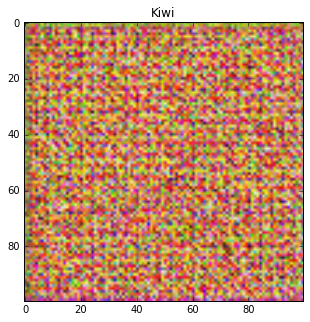

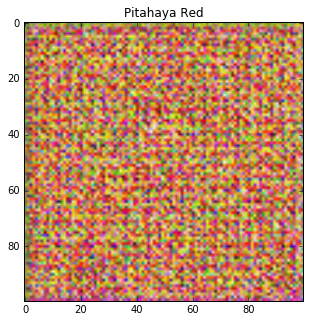

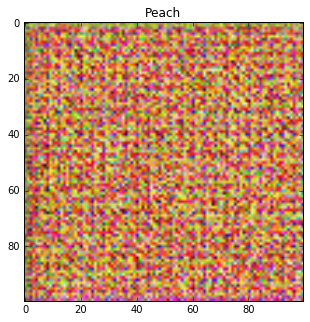

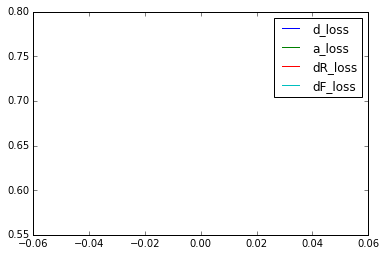

1
D1R
[0.42649829, 0.82440472]
D1F
[0.32666993, 0.8913691]


In [ ]:
for a in range(10000):
    print (a+0)
    TrainD()
    TrainG()
    if(a % 25 == 0):
        for b in range(3):
            name = 'img/'+str(a)+'-'+str(b)+'.png'
            Show(name)
    ShowPlt()

In [ ]:
modelTD.load_weights('modelTD5_weights.h5')
modelTA.load_weights('modelTA5_weights.h5')

In [ ]:
modelTD.save('modelDFruit.h5') 
modelTA.save('modelTFruit.h5') 
modelTD.save_weights('modelDFruit_weights.h5')
modelTA.save_weights('modelAFruit_weights.h5')


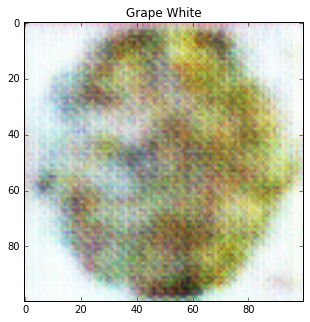

In [133]:
Show('k.png')
